# Instrumental folder generation for CMWP

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cmwp_tools
from lmfit.models import ExponentialModel, LinearModel,  GaussianModel, PseudoVoigtModel, SkewedVoigtModel, SkewedGaussianModel
from scipy.interpolate import CubicSpline

## Set paramaters

In [147]:
a = 4.15691                  # a lattice paramater in angstrom             
wavelength = 1.540598         # Wavelength in angstrom

inputfile = '/home/rhys/Documents/CMWP-201225/BOR60/NI/LaB6.dat'
outfolder = '/home/rhys/Desktop/test'

In [148]:
peak_name, peak_pos = cmwp_tools.getReflections(crystalType='cubic',outputType='2theta', a=a, wavelength=wavelength, printReflections=False)
_, peak_pos_k = cmwp_tools.getReflections(crystalType='cubic', outputType='k', a=a, wavelength=wavelength, printReflections=False)
peak_pos_k_nm = peak_pos_k*10

In [149]:
if not os.path.exists(outfolder):
    os.makedirs(outfolder)

x_2theta, y = np.loadtxt(inputfile, unpack=True)

x_k_nm = 10 * 2 * np.sin(np.deg2rad(np.array(x_2theta)/2)) / wavelength

## Plot data

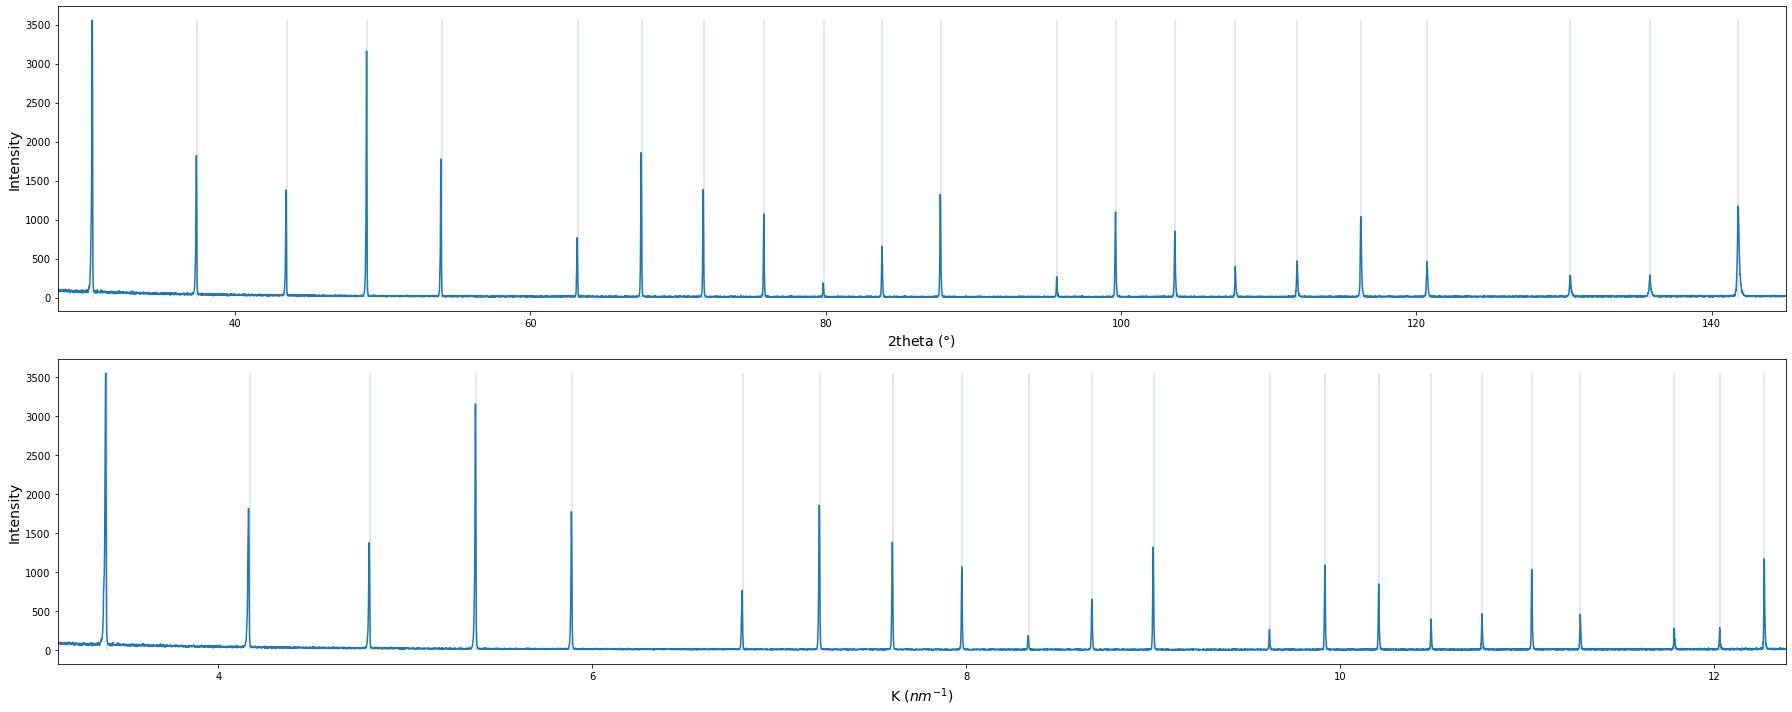

In [150]:
fig, (ax2, ax) = plt.subplots(2, 1, figsize=(25,10))
ax.vlines(peak_pos_k_nm, ymin=0, ymax=np.max(y), alpha=0.2)
ax.plot(x_k_nm, y, '-')
ax.set_xlabel('K ($nm^{-1}$)', fontsize=14); ax.set_ylabel('Intensity', fontsize=14);
ax.set_xlim(np.min(x_k_nm), np.max(x_k_nm))

ax2.vlines(peak_pos, alpha=0.2, ymin=0, ymax=np.max(y))
ax2.plot(x_2theta, y, '-')
ax2.set_xlabel('2theta ($\degree$)', fontsize=14); ax2.set_ylabel('Intensity', fontsize=14);
ax2.set_xlim(np.min(x_2theta), np.max(x_2theta))
plt.tight_layout()

In [151]:
## Subtract background

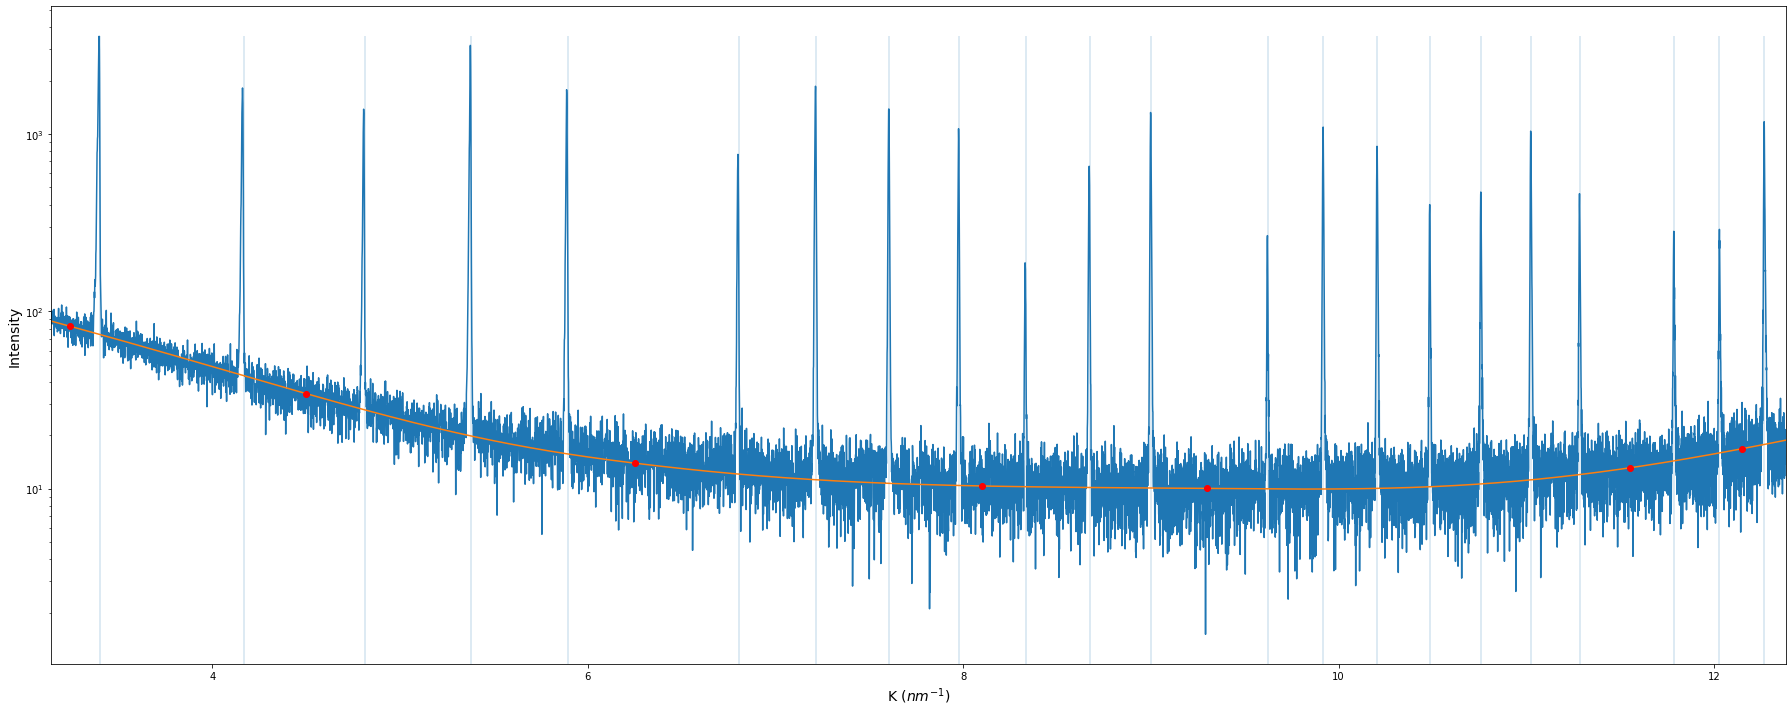

In [179]:
fig, ax = plt.subplots(1, 1, figsize=(25,10))
ax.vlines(peak_pos_k_nm, ymin=0, ymax=np.max(y), alpha=0.2)
ax.plot(x_k_nm, y, '-')
ax.set_xlabel('K ($nm^{-1}$)', fontsize=14); ax.set_ylabel('Intensity', fontsize=14);
ax.set_xlim(np.min(x_k_nm), np.max(x_k_nm))
ax.set_yscale('log')


plt.tight_layout()

baseline = [3.24, 4.5, 6.25, 8.1, 9.3, 11.55, 12.15]
baseline_int=[]

for j in baseline:
    num_index =np.argmin(np.abs(x_k_nm-j))
    baseline_int.append(np.mean(y[num_index-10:num_index+10]))
        
cs = CubicSpline(baseline, baseline_int)

ax.plot(x_k_nm, cs(x_k_nm))
ax.plot(baseline, baseline_int, c='r', marker='o', linewidth=0)

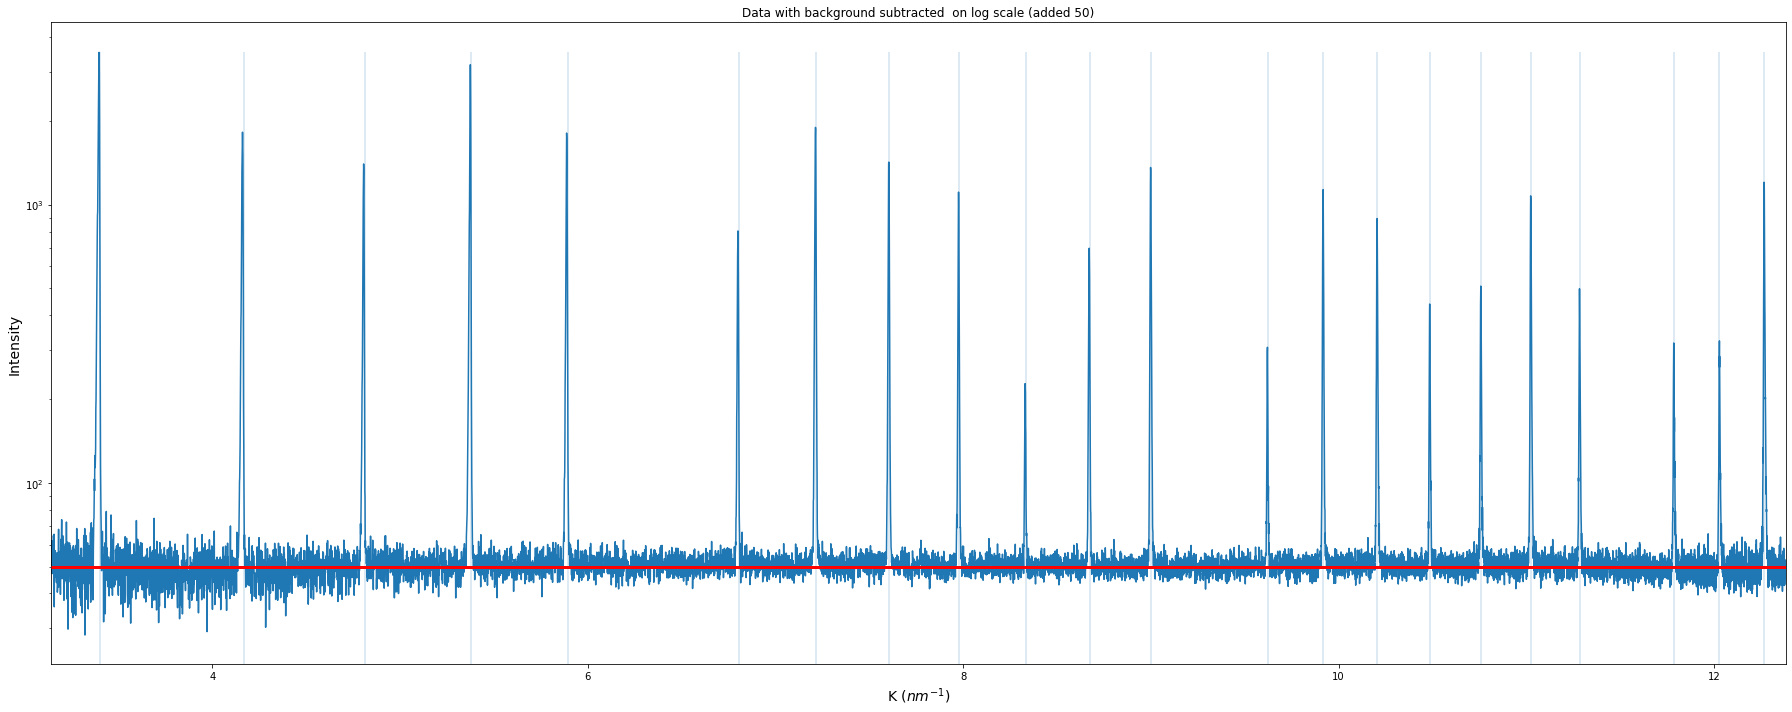

In [184]:
fig, ax = plt.subplots(1, 1, figsize=(25,10))
ax.vlines(peak_pos_k_nm, ymin=0, ymax=np.max(y), alpha=0.2)

y_nobck = y-cs(x_k_nm)
ax.plot(x_k_nm, y_nobck+50, '-')
ax.set_xlabel('K ($nm^{-1}$)', fontsize=14); ax.set_ylabel('Intensity', fontsize=14);
ax.set_xlim(np.min(x_k_nm), np.max(x_k_nm))
ax.set_yscale('log')
ax.hlines([50], colors='r', linewidth=3, xmin=np.min(x_k_nm), xmax=np.max(x_k_nm), zorder=20)
plt.title('Data with background subtracted  on log scale (added 50)')
plt.tight_layout()


## Fit peaks

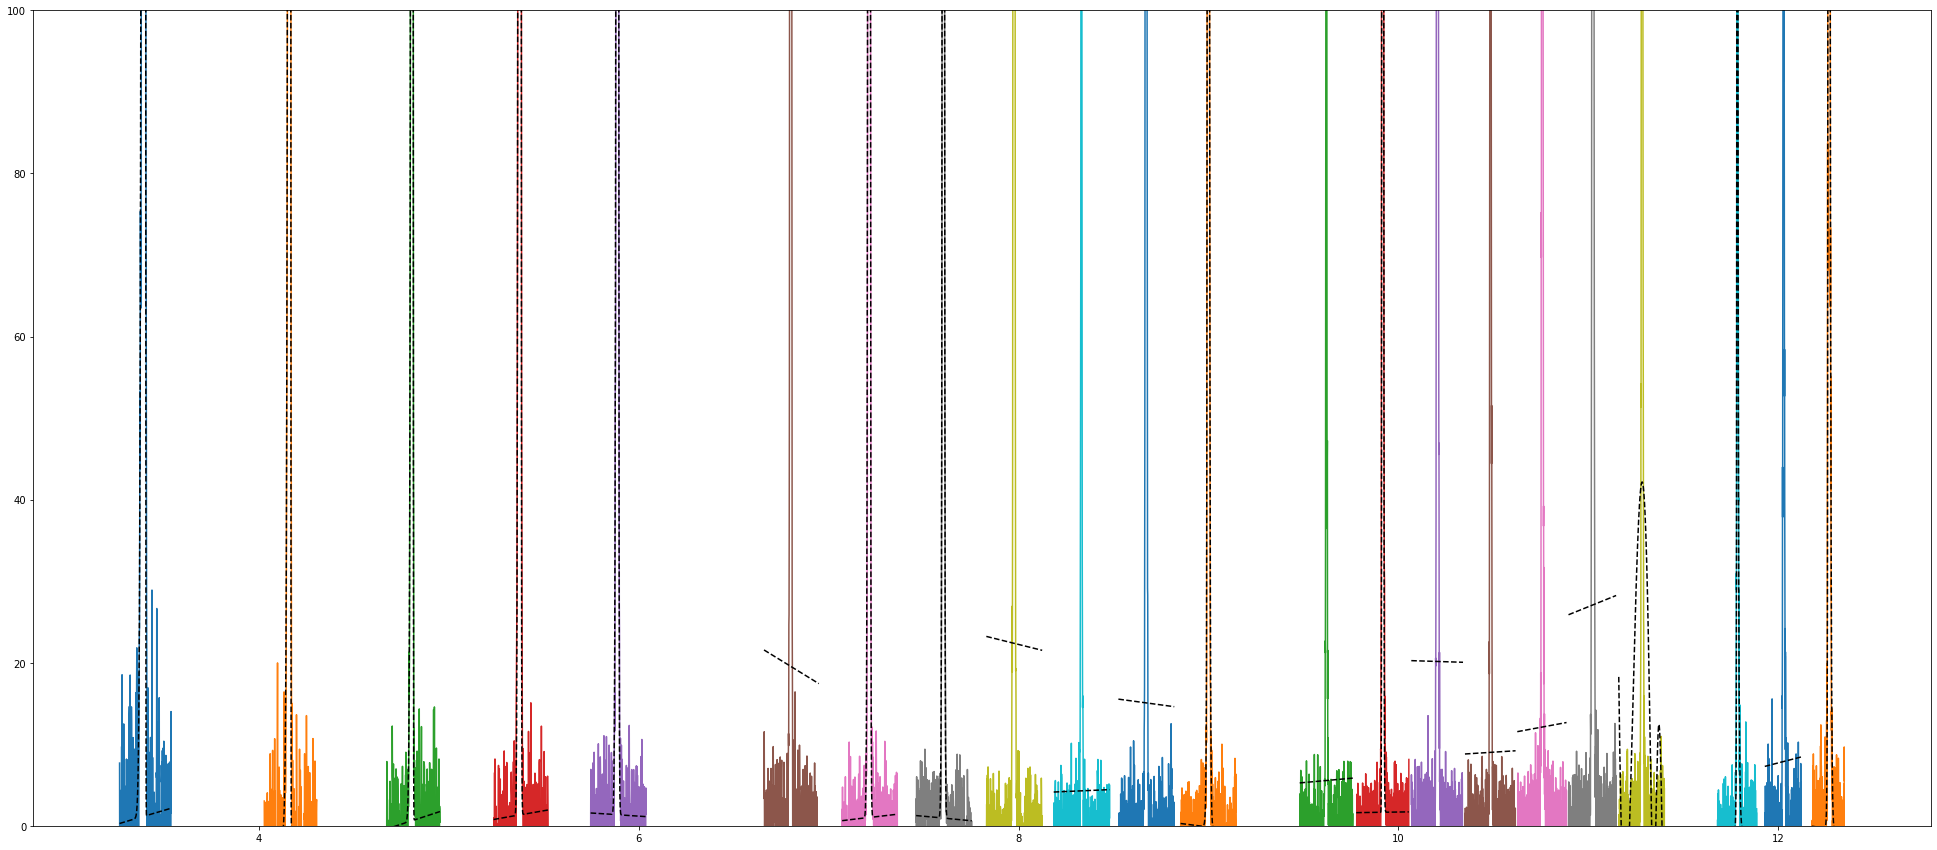

In [191]:
comp_list=[]
plt.figure(figsize=(34, 15))
# Fit each peak independently
for i, peak in enumerate(peak_pos_k_nm):
    print('Peak {0} of {1}      '.format(i+1, len(peak_pos_k_nm)), end='\r')
    if np.min(x_k_nm) < peak < np.max(x_k_nm):
        
        search = 120 + i*5
        searchrange = 10
        
        elem = np.abs(x_k_nm-peak).argmin()
                 

        peak_index = np.argmax(y_nobck[elem-searchrange:elem+searchrange])+elem-searchrange
        peak = x_k_nm[peak_index]
        
        
        
        xvals = x_k_nm[elem-search:elem+search]
        yvals = y_nobck[elem-search:elem+search]
        plt.plot(xvals, yvals)

        mod = LinearModel(prefix='exp_') + (SkewedGaussianModel(prefix='g0_') * SkewedVoigtModel(prefix='g1_'))
        pars = mod.make_params()

        pars['g0_center'].set(value=peak, min=peak-0.2, max=peak+0.2)
        pars['g0_sigma'].set(value=0.01, min=0.001, max=0.1)
        pars['g0_height'].set(value=(np.max(yvals)-np.min(yvals)), min=2)
        pars['g1_center'].set(value=peak, min=peak-0.2, max=peak+0.2)
        pars['g1_sigma'].set(value=0.01, min=0.001, max=0.1)
        pars['g1_height'].set(value=(np.max(yvals)-np.min(yvals)), min=2)

        init = mod.eval(pars, x=xvals)
        out = mod.fit(yvals, pars, x=xvals)
        #print(out.fit_report(min_correl=0.5))

        comp_list.append(out.eval_components(x=xvals))

        plt.plot(xvals, out.eval_components(x=xvals)['exp_']+(out.eval_components(x=xvals)['g0_']*out.eval_components(x=xvals)['g1_']), 'k--')
        plt.ylim(0, 100)
        
        axes.legend(loc='best')
        axes.set_title('Raw data and fit', fontsize=14)
        axes.set_xlabel('K ($nm^{-1}$)', fontsize=14); axes.set_ylabel('Intensity', fontsize=14);


## Save instrumental folder

In [ ]:
if not os.path.exists(outfolder):
    os.makedirs(outfolder)
    
for i, peak in enumerate(peak_pos_k_nm):
    print('Peak {0} of {1}      '.format(i+1, len(peak_pos_k_nm)), end='\r')
    if np.min(x_k_nm) < peak < np.max(x_k_nm):
        
        search = 120 + i*5
        
        elem = np.abs(x_k_nm-peak).argmin()
        xvals = x_k_nm[elem-search:elem+search]

        
        
        
    
        with open(outfolder + '/{0:.2f}'.format(peak), 'w') as outfile:
            np.savetxt(outfile, np.transpose([xvals-x_k+nm[elem],comp_list[i]['g0_']*comp_list[i]['g1_']]), fmt = ('%1.5f'))
        